In [24]:
from __future__ import absolute_import, division, print_function

import ast
import numpy as np

from rmexp import dbutils, config
from rmexp.schema import models
from logzero import logger
import matplotlib.pyplot as plt


In [25]:
# get the average processing time and
# data size for different partition
exp_cloudlet = 'lego-cloudlet002-2core'
exp_mobile = 'lego-nexus6'
exps = [exp_cloudlet, exp_mobile]
names = ['lego-tr{}'.format(idx) for idx in range(1, 6)]
sample_frame_ds = 691341


In [26]:


def get_data(exp, trace):
    """Get data for experimen exp and trace.
    Return cumulative processing time and datasize as 2D numpy array (frame_id, partiion)
    """
    logger.info('processing {} {}'.format(exp, trace))
    sess = dbutils.get_session()
    data = [[ast.literal_eval(item.speed), ast.literal_eval(item.data_length)]
            for item in sess.query(models.AppProfile.speed,
                                   models.AppProfile.data_length).filter(
                models.AppProfile.name == trace).filter(
                models.AppProfile.exp == exp).all()]
    sess.close()
    pt, ds = list(zip(*data))
    pt = np.array(pt)
    sample_pt = np.zeros((pt.shape[0], 1))
    if 'cloudlet' in exp:
        # cloudlet
        pt_rev = pt[:, ::-1]
        pt_rev = np.concatenate([sample_pt, pt_rev], axis=1)
        pct = np.cumsum(pt_rev, axis=1)[:, ::-1]
    else:
        # client
        pt = np.concatenate([sample_pt, pt], axis=1)
        pct = np.cumsum(pt, axis=1)

    ds = np.array(ds)
    sample_ds = np.full((ds.shape[0], 1),
                        sample_frame_ds, dtype=np.int64)
    ds = np.concatenate([sample_ds, ds], axis=1)
    return pct, ds



In [27]:
# summarize over all traces
data = {}
for exp in exps:
    pcts, dss = [], []
    for name in names:
        pct, ds = get_data(exp, name)
        pcts.append(pct)
        dss.append(ds)
    pcts, dss = np.concatenate(pcts), np.concatenate(dss)
    data[exp] = (pcts, dss)

[I 190508 15:01:17 <ipython-input-26-a95199784b3c>:7] processing lego-cloudlet002-2core lego-tr1
[I 190508 15:01:17 <ipython-input-26-a95199784b3c>:7] processing lego-cloudlet002-2core lego-tr2
[I 190508 15:01:17 <ipython-input-26-a95199784b3c>:7] processing lego-cloudlet002-2core lego-tr3
[I 190508 15:01:18 <ipython-input-26-a95199784b3c>:7] processing lego-cloudlet002-2core lego-tr4
[I 190508 15:01:18 <ipython-input-26-a95199784b3c>:7] processing lego-cloudlet002-2core lego-tr5
[I 190508 15:01:18 <ipython-input-26-a95199784b3c>:7] processing lego-nexus6 lego-tr1
[I 190508 15:01:18 <ipython-input-26-a95199784b3c>:7] processing lego-nexus6 lego-tr2
[I 190508 15:01:18 <ipython-input-26-a95199784b3c>:7] processing lego-nexus6 lego-tr3
[I 190508 15:01:18 <ipython-input-26-a95199784b3c>:7] processing lego-nexus6 lego-tr4
[I 190508 15:01:18 <ipython-input-26-a95199784b3c>:7] processing lego-nexus6 lego-tr5


<IPython.core.display.Javascript object>


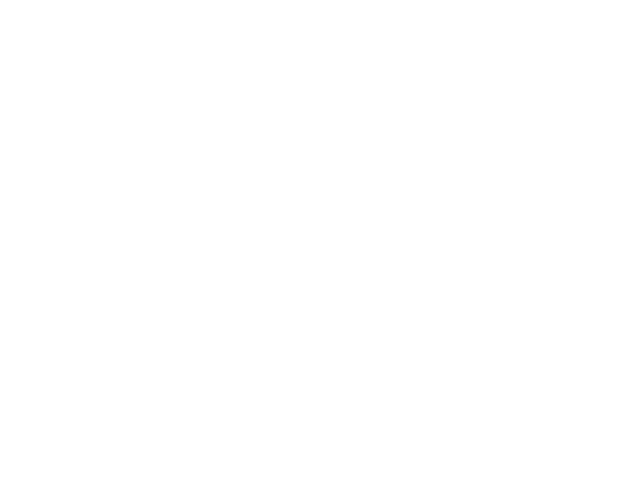

<IPython.core.display.Javascript object>


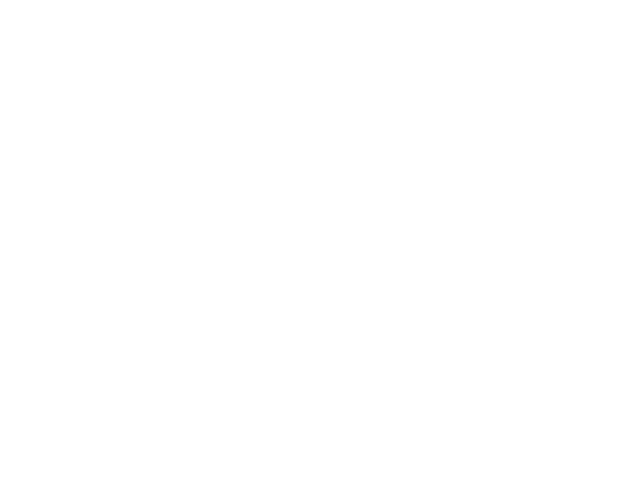

<IPython.core.display.Javascript object>


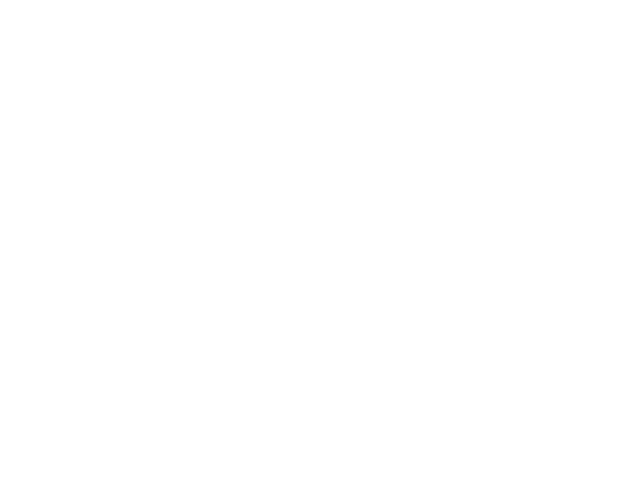

<IPython.core.display.Javascript object>


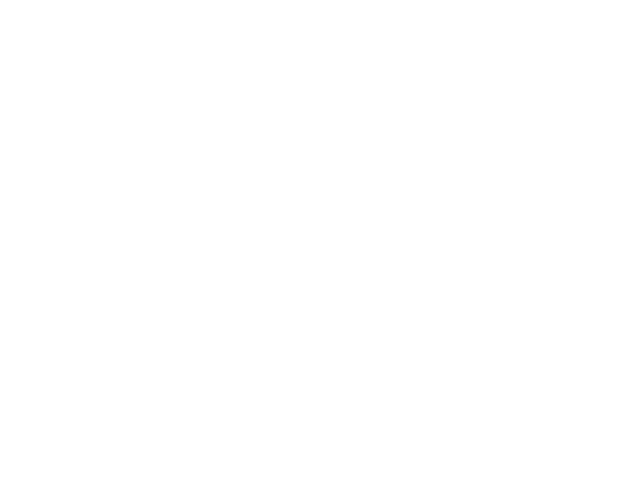

<IPython.core.display.Javascript object>


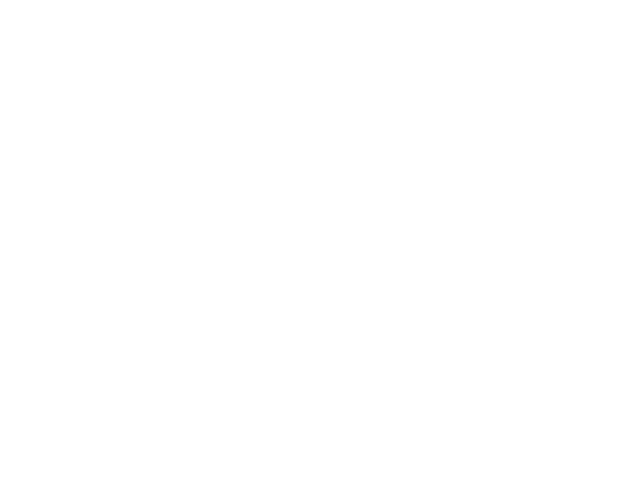

In [28]:
%matplotlib notebook

for i in range(5):
    plt.figure()
    plt.hist(data[exp_mobile][0][:, i])

<IPython.core.display.Javascript object>


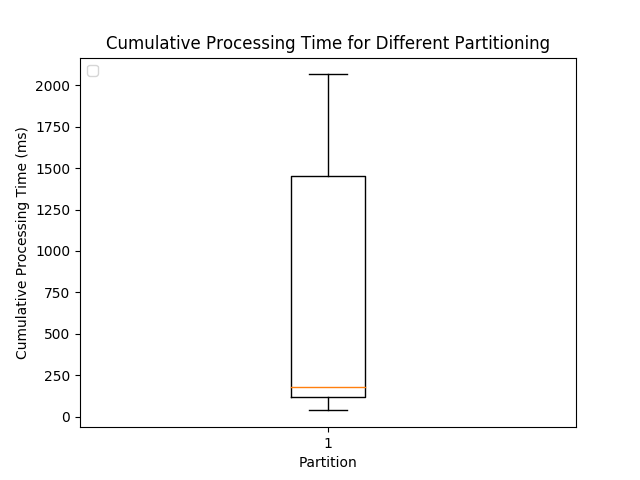

176.0

In [29]:
%matplotlib notebook

plt.figure()
plt.boxplot(data[exp_mobile][0][:, 4])
# plt.boxplot(data[exp_mobile][0])
plt.title('Cumulative Processing Time for Different Partitioning')
plt.xlabel('Partition')
plt.ylabel('Cumulative Processing Time (ms)')
plt.gca().legend(('cloudlet','client'))
plt.legend(loc='upper left')

np.median(data[exp_mobile][0][:, 4])

In [37]:
# calculate the average client and server processing time
logger.info('total frames: {}'.format(data[exp_mobile][0].shape))
logger.info('=========== Client Processing Time ===============')
logger.info('mean: {}'.format(np.round(np.mean(data[exp_mobile][0], axis=0))))
logger.info('std: {}'.format(np.round(np.std(data[exp_mobile][0], axis=0))))

logger.info('=========== Server Processing Time ===============')
logger.info('mean: {}'.format(np.round(np.mean(data[exp_cloudlet][0], axis=0))))
logger.info('std: {}'.format(np.round(np.std(data[exp_cloudlet][0], axis=0))))

logger.info('=========== Data Size (KBytes) ===============')
logger.info('mean: {}'.format(np.round(np.mean(data[exp_cloudlet][1], axis=0)/1024.0)))
logger.info('std: {}'.format(np.round(np.std(data[exp_cloudlet][1], axis=0)/1024.0)))


[I 190508 15:29:40 <ipython-input-37-2851d0aab72b>:2] total frames: (13739, 5)
[I 190508 15:29:40 <ipython-input-37-2851d0aab72b>:3] =========== Client Processing Time ===============
[I 190508 15:29:40 <ipython-input-37-2851d0aab72b>:4] mean: [   0.  186.  571.  608.  626.]
[I 190508 15:29:40 <ipython-input-37-2851d0aab72b>:5] std: [   0.   77.  570.  619.  643.]
[I 190508 15:29:40 <ipython-input-37-2851d0aab72b>:7] =========== Server Processing Time ===============
[I 190508 15:29:40 <ipython-input-37-2851d0aab72b>:8] mean: [ 179.  139.   18.    8.    0.]
[I 190508 15:29:40 <ipython-input-37-2851d0aab72b>:9] std: [ 199.  186.   25.   11.    0.]
[I 190508 15:29:40 <ipython-input-37-2851d0aab72b>:11] =========== Data Size (KBytes) ===============
[I 190508 15:29:40 <ipython-input-37-2851d0aab72b>:12] mean: [ 675.  310.  441.   88.    0.]
[I 190508 15:29:40 <ipython-input-37-2851d0aab72b>:13] std: [   0.  336.  589.  118.    0.]
